In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = config["source_epochs"]
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)
source_scaling = config["source_scaling"]

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/LensSR/Simulations/data_model_1/',['no_sub_sie'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)
s_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["s_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor(np.load('/home/anirudh/Documents/GSoC/LensSR/Simulations/data_model_1/no_sub_sie/alpha.npy')).to(device).type(torch.float32)
phy_loss = models.LensingLoss(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG,device=device,alpha=alpha, resolution=resolution, BATCH_SIZE=BATCH_SIZE, source_scaling=source_scaling).to(device)

opt = torch.optim.Adam(params=s_model.parameters(),lr=LR)
total_params = sum(p.numel() for p in s_model.parameters())
print(f"Number of parameters: {total_params}x2")

Number of parameters: 899843x2


In [6]:
def give_random_image(dataset, model1, model2, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE)
    t1 = model1(t.float().to(device)).cpu().detach()
    t2 = model2(t.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3, image4 = phy_loss.get_samples(t1.to(device))
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2, Image.fromarray(image3.cpu().numpy()[0][0]*255), Image.fromarray(image4.cpu().numpy()[0][0]*255))

def show_random_image(image_tuple):
    image0, image1, image2, image3, image4 = image_tuple[0], image_tuple[1], image_tuple[2], image_tuple[3], image_tuple[4]
    plot, axes = plt.subplots(1,5)
    plot.set_size_inches(30,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[3].imshow(image3)
    axes[4].imshow(image4)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Source_network")
    axes[3].set_title("Source_regenerated")
    axes[4].set_title("Source_true")

In [7]:
i_model.load_state_dict(torch.load('bicubic.pt'))

<All keys matched successfully>

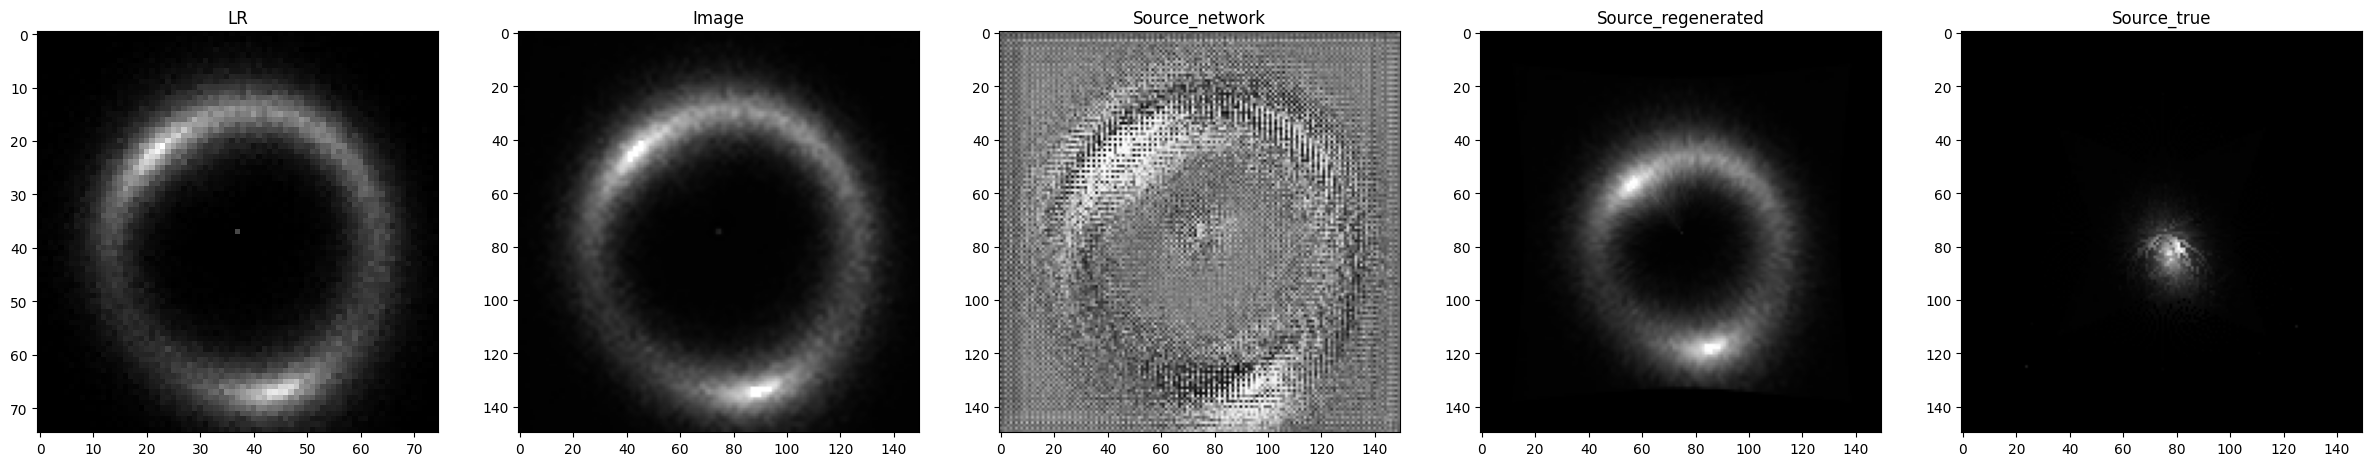

In [8]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))

In [9]:
best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[]}
for epoch in range(EPOCHS):
    losses = []
    i_model.eval()
    s_model.train()
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        loss = phy_loss(source, image, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    i_model.eval()
    s_model.eval()
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        # k_tensor = k_model(x)
        val_loss = phy_loss(source, image, x)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = s_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")

Training epoch 1: 100%|██████████| 800/800 [01:06<00:00, 12.10it/s]


Training at epoch 1/50: 0.29279925068840384 at LR=0.0001


Validation epoch 1: 100%|██████████| 200/200 [00:06<00:00, 32.94it/s]


Validation at epoch 1/50: 0.2872756142914295 at LR=0.0001


Training epoch 2: 100%|██████████| 800/800 [01:06<00:00, 12.03it/s]


Training at epoch 2/50: 0.2564261556789279 at LR=0.0001


Validation epoch 2: 100%|██████████| 200/200 [00:06<00:00, 32.99it/s]


Validation at epoch 2/50: 0.24677600972354413 at LR=0.0001


Training epoch 3: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 3/50: 0.22730929605662822 at LR=0.0001


Validation epoch 3: 100%|██████████| 200/200 [00:06<00:00, 32.65it/s]


Validation at epoch 3/50: 0.21257183954119682 at LR=0.0001


Training epoch 4: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 4/50: 0.2015153881162405 at LR=0.0001


Validation epoch 4: 100%|██████████| 200/200 [00:06<00:00, 32.69it/s]


Validation at epoch 4/50: 0.19178603850305082 at LR=0.0001


Training epoch 5: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 5/50: 0.1783708568662405 at LR=0.0001


Validation epoch 5: 100%|██████████| 200/200 [00:06<00:00, 32.48it/s]


Validation at epoch 5/50: 0.16694774299860002 at LR=0.0001


Training epoch 6: 100%|██████████| 800/800 [01:07<00:00, 11.94it/s]


Training at epoch 6/50: 0.15764534376561642 at LR=0.0001


Validation epoch 6: 100%|██████████| 200/200 [00:06<00:00, 32.70it/s]


Validation at epoch 6/50: 0.14250529691576957 at LR=0.0001


Training epoch 7: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 7/50: 0.13890732910484074 at LR=0.0001


Validation epoch 7: 100%|██████████| 200/200 [00:06<00:00, 32.67it/s]


Validation at epoch 7/50: 0.1393445820361376 at LR=0.0001


Training epoch 8: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 8/50: 0.12228239529766143 at LR=0.0001


Validation epoch 8: 100%|██████████| 200/200 [00:06<00:00, 32.92it/s]


Validation at epoch 8/50: 0.1150345204770565 at LR=0.0001


Training epoch 9: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 9/50: 0.10722639046609402 at LR=0.0001


Validation epoch 9: 100%|██████████| 200/200 [00:06<00:00, 32.88it/s]


Validation at epoch 9/50: 0.0946819482371211 at LR=0.0001


Training epoch 10: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 10/50: 0.09386885710991918 at LR=0.0001


Validation epoch 10: 100%|██████████| 200/200 [00:06<00:00, 32.61it/s]


Validation at epoch 10/50: 0.0943262667581439 at LR=0.0001


Training epoch 11: 100%|██████████| 800/800 [01:06<00:00, 11.94it/s]


Training at epoch 11/50: 0.08206355550326407 at LR=0.0001


Validation epoch 11: 100%|██████████| 200/200 [00:06<00:00, 32.64it/s]


Validation at epoch 11/50: 0.07935579068958759 at LR=0.0001


Training epoch 12: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 12/50: 0.07136075908318162 at LR=0.0001


Validation epoch 12: 100%|██████████| 200/200 [00:06<00:00, 32.89it/s]


Validation at epoch 12/50: 0.06525001730769872 at LR=0.0001


Training epoch 13: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 13/50: 0.062016902826726436 at LR=0.0001


Validation epoch 13: 100%|██████████| 200/200 [00:06<00:00, 32.86it/s]


Validation at epoch 13/50: 0.05608030995354056 at LR=0.0001


Training epoch 14: 100%|██████████| 800/800 [01:06<00:00, 11.94it/s]


Training at epoch 14/50: 0.053780919406563044 at LR=0.0001


Validation epoch 14: 100%|██████████| 200/200 [00:06<00:00, 32.72it/s]


Validation at epoch 14/50: 0.04773627007380128 at LR=0.0001


Training epoch 15: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 15/50: 0.046441959594376386 at LR=0.0001


Validation epoch 15: 100%|██████████| 200/200 [00:06<00:00, 32.65it/s]


Validation at epoch 15/50: 0.03904127711430192 at LR=0.0001


Training epoch 16: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 16/50: 0.04007835738360882 at LR=0.0001


Validation epoch 16: 100%|██████████| 200/200 [00:06<00:00, 32.59it/s]


Validation at epoch 16/50: 0.035916534774005415 at LR=0.0001


Training epoch 17: 100%|██████████| 800/800 [01:06<00:00, 11.94it/s]


Training at epoch 17/50: 0.03445630205329508 at LR=0.0001


Validation epoch 17: 100%|██████████| 200/200 [00:06<00:00, 32.80it/s]


Validation at epoch 17/50: 0.029782062778249383 at LR=0.0001


Training epoch 18: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 18/50: 0.02960968155646697 at LR=0.0001


Validation epoch 18: 100%|██████████| 200/200 [00:06<00:00, 32.62it/s]


Validation at epoch 18/50: 0.02748308891430497 at LR=0.0001


Training epoch 19: 100%|██████████| 800/800 [01:06<00:00, 11.96it/s]


Training at epoch 19/50: 0.025316635717172176 at LR=0.0001


Validation epoch 19: 100%|██████████| 200/200 [00:06<00:00, 32.83it/s]


Validation at epoch 19/50: 0.022541509307920933 at LR=0.0001


Training epoch 20: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 20/50: 0.021641838751966135 at LR=0.0001


Validation epoch 20: 100%|██████████| 200/200 [00:06<00:00, 32.87it/s]


Validation at epoch 20/50: 0.020673682494089008 at LR=0.0001


Training epoch 21: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 21/50: 0.018431730441516265 at LR=0.0001


Validation epoch 21: 100%|██████████| 200/200 [00:06<00:00, 32.72it/s]


Validation at epoch 21/50: 0.01284315763041377 at LR=0.0001


Training epoch 22: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 22/50: 0.015690857043955474 at LR=0.0001


Validation epoch 22: 100%|██████████| 200/200 [00:06<00:00, 32.42it/s]


Validation at epoch 22/50: 0.014926858879625797 at LR=0.0001


Training epoch 23: 100%|██████████| 800/800 [01:06<00:00, 11.94it/s]


Training at epoch 23/50: 0.013288409073138609 at LR=0.0001


Validation epoch 23: 100%|██████████| 200/200 [00:06<00:00, 32.90it/s]


Validation at epoch 23/50: 0.011671892073936761 at LR=0.0001


Training epoch 24: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 24/50: 0.011250166809768416 at LR=0.0001


Validation epoch 24: 100%|██████████| 200/200 [00:06<00:00, 32.63it/s]


Validation at epoch 24/50: 0.010416347444988787 at LR=0.0001


Training epoch 25: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 25/50: 0.009522121543996035 at LR=0.0001


Validation epoch 25: 100%|██████████| 200/200 [00:06<00:00, 32.81it/s]


Validation at epoch 25/50: 0.008114336833823472 at LR=0.0001


Training epoch 26: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 26/50: 0.008033802050631493 at LR=0.0001


Validation epoch 26: 100%|██████████| 200/200 [00:06<00:00, 32.65it/s]


Validation at epoch 26/50: 0.00817899112123996 at LR=0.0001


Training epoch 27: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 27/50: 0.006756994822062552 at LR=0.0001


Validation epoch 27: 100%|██████████| 200/200 [00:06<00:00, 32.75it/s]


Validation at epoch 27/50: 0.006889028321020305 at LR=0.0001


Training epoch 28: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 28/50: 0.005697458818031009 at LR=0.0001


Validation epoch 28: 100%|██████████| 200/200 [00:06<00:00, 32.75it/s]


Validation at epoch 28/50: 0.005809729129541665 at LR=0.0001


Training epoch 29: 100%|██████████| 800/800 [01:06<00:00, 11.94it/s]


Training at epoch 29/50: 0.004799790655088145 at LR=0.0001


Validation epoch 29: 100%|██████████| 200/200 [00:06<00:00, 32.89it/s]


Validation at epoch 29/50: 0.004079902184894308 at LR=0.0001


Training epoch 30: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 30/50: 0.00406118289771257 at LR=0.0001


Validation epoch 30: 100%|██████████| 200/200 [00:06<00:00, 32.91it/s]


Validation at epoch 30/50: 0.0032543506124056874 at LR=0.0001


Training epoch 31: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 31/50: 0.0034176214682520366 at LR=0.0001


Validation epoch 31: 100%|██████████| 200/200 [00:06<00:00, 32.91it/s]


Validation at epoch 31/50: 0.0026493882364593446 at LR=0.0001


Training epoch 32: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 32/50: 0.00291262592698331 at LR=0.0001


Validation epoch 32: 100%|██████████| 200/200 [00:06<00:00, 32.66it/s]


Validation at epoch 32/50: 0.0022051293816184626 at LR=0.0001


Training epoch 33: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 33/50: 0.002506645758403465 at LR=0.0001


Validation epoch 33: 100%|██████████| 200/200 [00:06<00:00, 32.71it/s]


Validation at epoch 33/50: 0.002487429492175579 at LR=0.0001


Training epoch 34: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 34/50: 0.0021080198520212435 at LR=0.0001


Validation epoch 34: 100%|██████████| 200/200 [00:06<00:00, 32.52it/s]


Validation at epoch 34/50: 0.0021823479619342834 at LR=0.0001


Training epoch 35: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 35/50: 0.001847309496224625 at LR=0.0001


Validation epoch 35: 100%|██████████| 200/200 [00:06<00:00, 32.88it/s]


Validation at epoch 35/50: 0.0014096941455500201 at LR=0.0001


Training epoch 36: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 36/50: 0.0016253246473206674 at LR=0.0001


Validation epoch 36: 100%|██████████| 200/200 [00:06<00:00, 33.10it/s]


Validation at epoch 36/50: 0.0013952939247246833 at LR=0.0001


Training epoch 37: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 37/50: 0.0014738474079058505 at LR=0.0001


Validation epoch 37: 100%|██████████| 200/200 [00:06<00:00, 32.88it/s]


Validation at epoch 37/50: 0.0014675597916357218 at LR=0.0001


Training epoch 38: 100%|██████████| 800/800 [01:06<00:00, 11.94it/s]


Training at epoch 38/50: 0.001290993517759489 at LR=0.0001


Validation epoch 38: 100%|██████████| 200/200 [00:06<00:00, 32.91it/s]


Validation at epoch 38/50: 0.0010381480134674349 at LR=0.0001


Training epoch 39: 100%|██████████| 800/800 [01:06<00:00, 11.95it/s]


Training at epoch 39/50: 0.001238109076512046 at LR=0.0001


Validation epoch 39: 100%|██████████| 200/200 [00:06<00:00, 33.05it/s]


Validation at epoch 39/50: 0.000980926571355667 at LR=0.0001


Training epoch 40: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 40/50: 0.0011223998255445622 at LR=0.0001


Validation epoch 40: 100%|██████████| 200/200 [00:06<00:00, 32.97it/s]


Validation at epoch 40/50: 0.0010994381937780417 at LR=0.0001


Training epoch 41: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 41/50: 0.001005734153877711 at LR=0.0001


Validation epoch 41: 100%|██████████| 200/200 [00:06<00:00, 32.99it/s]


Validation at epoch 41/50: 0.0008968051735428162 at LR=0.0001


Training epoch 42: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 42/50: 0.0009632699329813477 at LR=0.0001


Validation epoch 42: 100%|██████████| 200/200 [00:06<00:00, 32.95it/s]


Validation at epoch 42/50: 0.000843889212119393 at LR=0.0001


Training epoch 43: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 43/50: 0.0009850998898036777 at LR=0.0001


Validation epoch 43: 100%|██████████| 200/200 [00:06<00:00, 33.09it/s]


Validation at epoch 43/50: 0.0008664959738962353 at LR=0.0001


Training epoch 44: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 44/50: 0.0008755150848446647 at LR=0.0001


Validation epoch 44: 100%|██████████| 200/200 [00:06<00:00, 32.94it/s]


Validation at epoch 44/50: 0.0007706990416045301 at LR=0.0001


Training epoch 45: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 45/50: 0.0008809259796544211 at LR=0.0001


Validation epoch 45: 100%|██████████| 200/200 [00:06<00:00, 33.00it/s]


Validation at epoch 45/50: 0.0008611103740986437 at LR=0.0001


Training epoch 46: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 46/50: 0.0008344649001082871 at LR=0.0001


Validation epoch 46: 100%|██████████| 200/200 [00:06<00:00, 32.79it/s]


Validation at epoch 46/50: 0.0006976970062532927 at LR=0.0001


Training epoch 47: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 47/50: 0.0008202661271934631 at LR=0.0001


Validation epoch 47: 100%|██████████| 200/200 [00:06<00:00, 32.17it/s]


Validation at epoch 47/50: 0.000708209388249088 at LR=0.0001


Training epoch 48: 100%|██████████| 800/800 [01:07<00:00, 11.93it/s]


Training at epoch 48/50: 0.0008233196009678068 at LR=0.0001


Validation epoch 48: 100%|██████████| 200/200 [00:06<00:00, 32.31it/s]


Validation at epoch 48/50: 0.0006924960779724642 at LR=0.0001


Training epoch 49: 100%|██████████| 800/800 [01:07<00:00, 11.91it/s]


Training at epoch 49/50: 0.0007989031950273784 at LR=0.0001


Validation epoch 49: 100%|██████████| 200/200 [00:06<00:00, 32.23it/s]


Validation at epoch 49/50: 0.0006616714913980104 at LR=0.0001


Training epoch 50: 100%|██████████| 800/800 [01:07<00:00, 11.86it/s]


Training at epoch 50/50: 0.0008146417221723823 at LR=0.0001


Validation epoch 50: 100%|██████████| 200/200 [00:06<00:00, 31.95it/s]

Validation at epoch 50/50: 0.0007938179458142258 at LR=0.0001


In [10]:
s_model.load_state_dict(best_weights)
torch.save(s_model.state_dict(),'s_weight.pt')

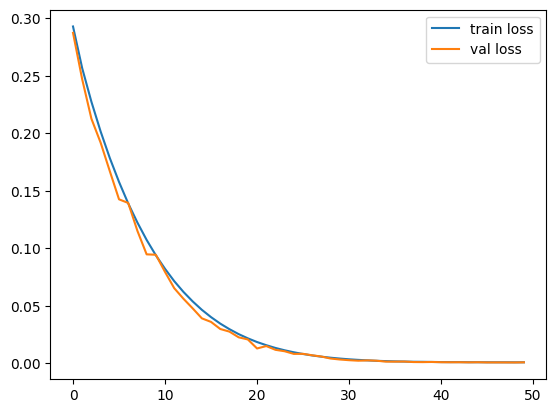

In [11]:
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'],label='val loss')
plt.legend()

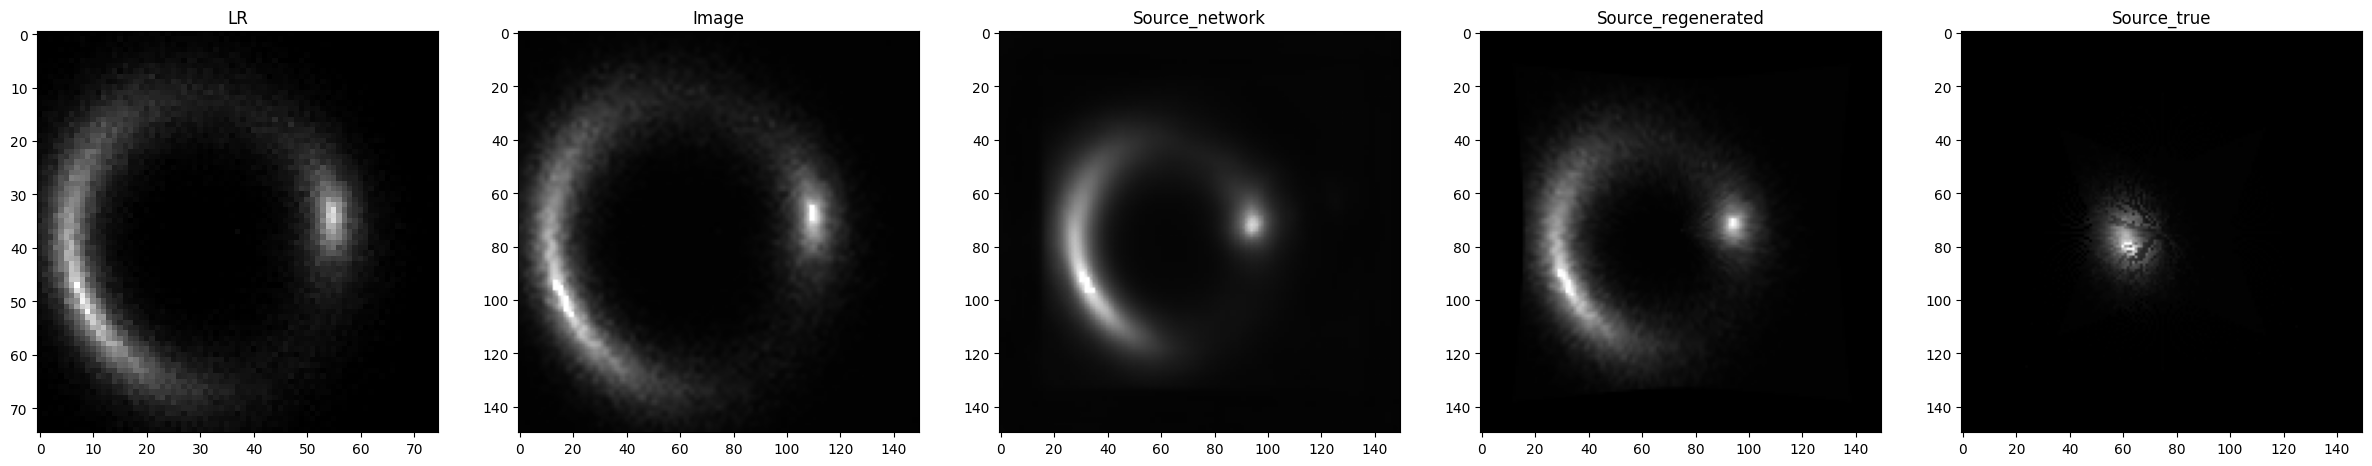

In [12]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))